**Saad Khan and Veer Khosla**

Fall 2024

CS 343: Neural Networks

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

plt.show()
plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 16})

np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

## TensorFlow install test

*Sanity check that TensorFlow is installed correctly:*

Executing the following cell should print 3 

In [3]:
tf.print(tf.reduce_sum([tf.constant(1), tf.constant(2)]))

3


# Project 4 | Transfer Learning

## Task 1: Implement ConvNet4AccelV2 in TensorFlow

Construct the familiar `ConvNet4AccelV2` neural network architecture from last project in TensorFlow's high level `Keras::Sequential` API. Also like your last project, train on the STL-10 training set and test on the STL-10 test set.

### 1a. Use the high level `Keras::Sequential` API in TensorFlow to implement the architecture of ConvNet4AccelV2 from the last project. Train and test your network on the STL-10 dataset. 

**Goal:** Achieve ≥ 47% on either the validation set or test set. *For our purposes, getting ≥ 47% validation accuracy at any point during training is enough (i.e. doesn't need to be at the very end of training).*

#### Notes

- You should use the usual STL-10 data acquisition and preprocessing code from your last project. You can use the default split, or modify it yourself.
- You don't need to do a hyperparameter search. Values that worked on the CNN project should get you in the ballpark here. The goal is to show that you know how to put together a `keras::Sequential` model and have it work successfully.
- You may have to tweak the hyperparameters by hand a little (number of epochs, regularization, number of hidden units, etc.) to hit your accuracy target, but it should not take too much effort.
- TensorFlow needs the RGB color channel AFTER the spatial dimensions. For example: (32, 32, 3), not (3, 32, 32). You may therefore need to slightly modify the preprocesssing pipeline for this project.

#### Keras Sequential workflow

Recall the `Keras::Sequential` common workflow:

- Build structure of network with `Keras::Sequential`.
- Compile network with your choice of optimizer, loss, and metrics.
- Fit the model (remembering to pass in the appropriate training and validation sets). This results a history object that can be used to examine training/validation accuracy and loss.
- Evaluate the model on the test set. This returns test loss and accuracy.

#### Helpful documentation

These documentation pages should be helpful:
- https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#summary

In [4]:
import load_stl10_dataset
from preprocess_data import load_stl10

Images are: (5000, 96, 96, 3)
Labels are: (5000,)
Resizing 5000 images to 32x32...Done!
Saving Numpy arrays the images and labels to ./numpy...Done!


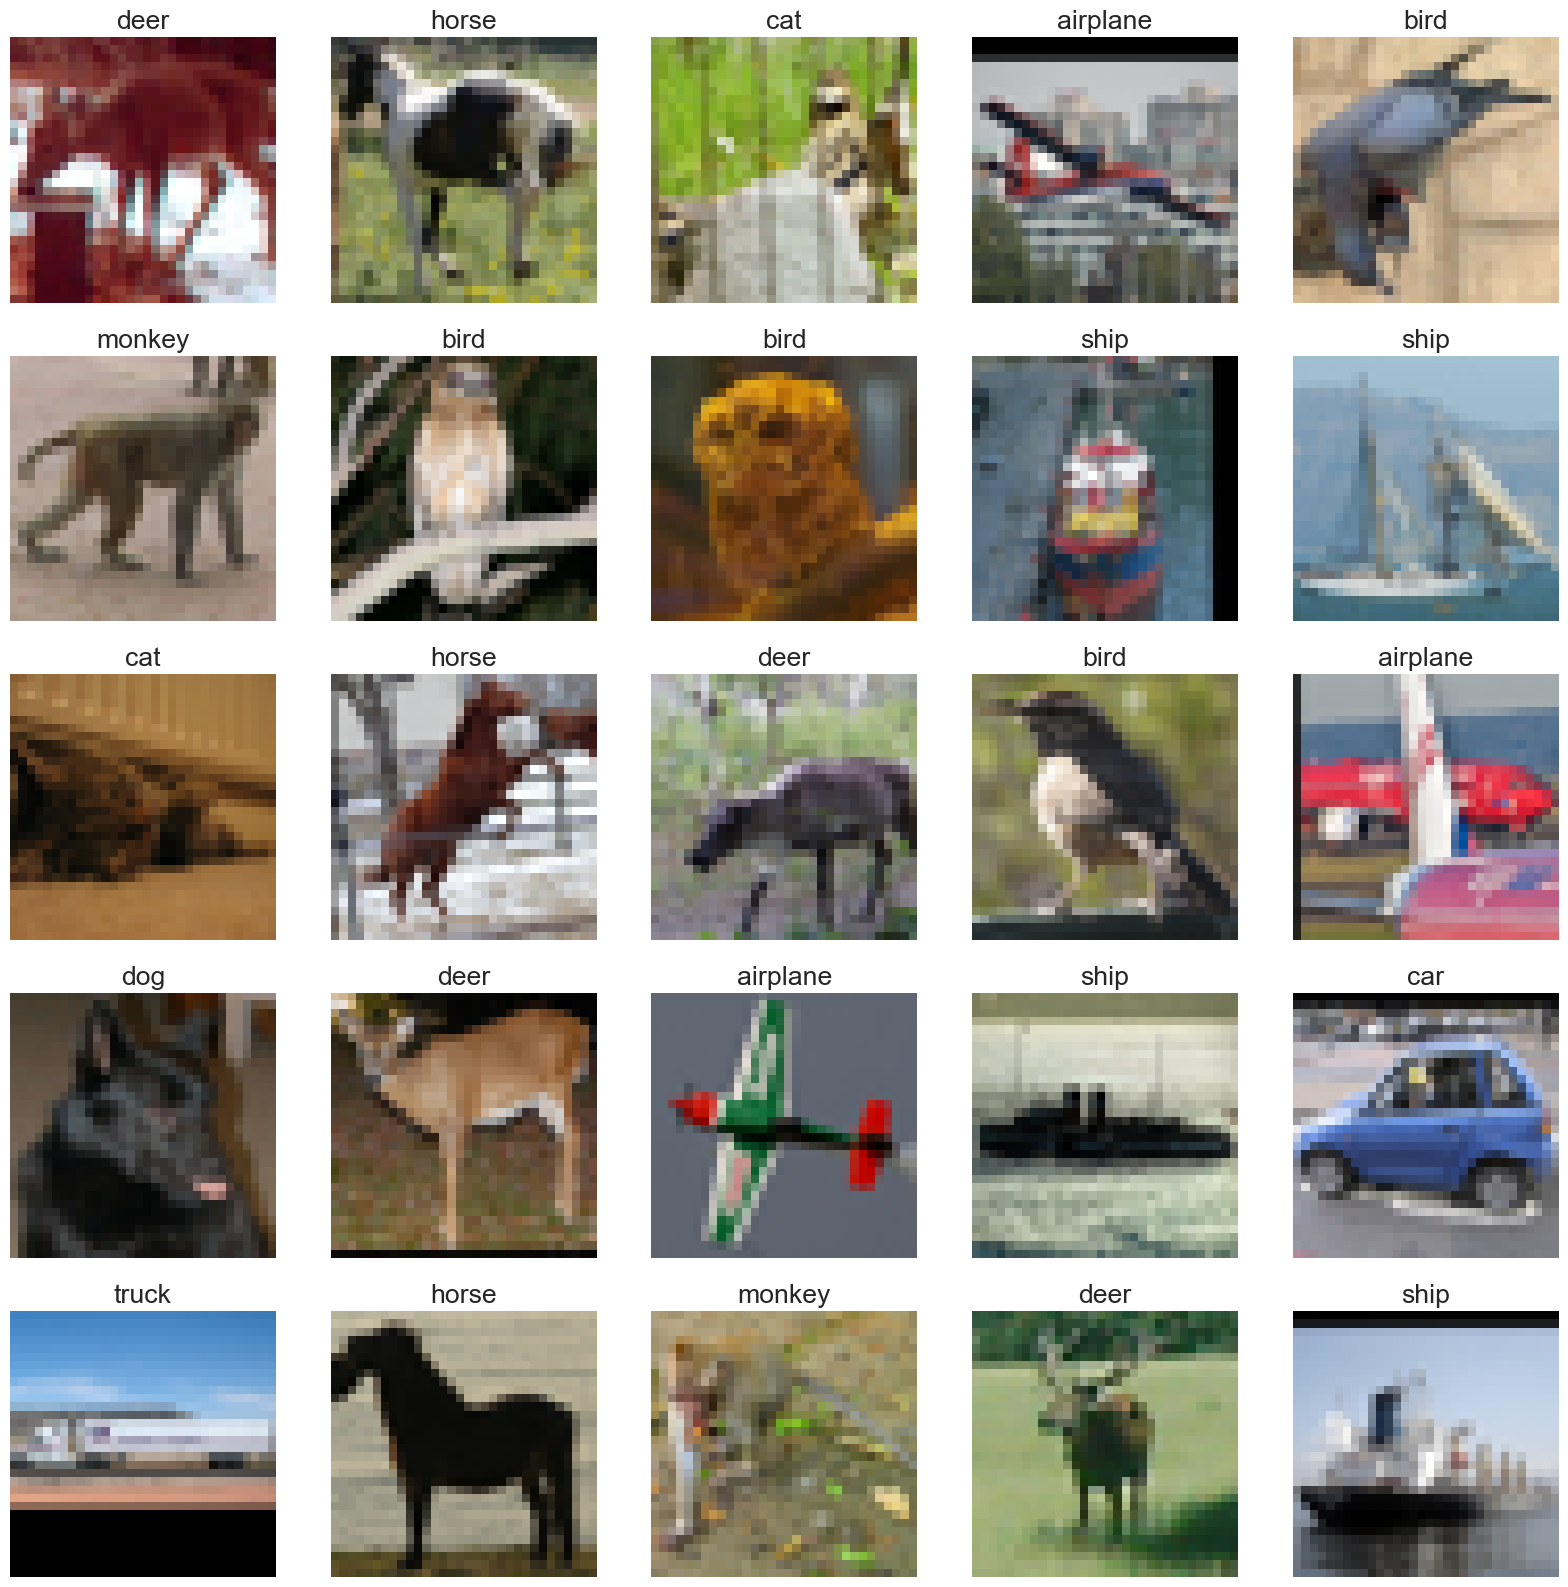

Found cached numpy arrays the images and labels. Loading them...
Images are: (5000, 32, 32, 3)
Labels are: (5000,)
Training data shape: (3000, 32, 32, 3)
Validation data shape: (1000, 32, 32, 3)
Training labels shape: (3000,)
Validation labels shape: (1000,)


In [5]:
classes = np.loadtxt(os.path.join('data', 'stl10_binary', 'class_names.txt'), dtype=str)

load_stl10_dataset.purge_cached_dataset()

# YOUR CODE HERE
import random
# Load the STL-10 dataset
stl_imgs, stl_labels = load_stl10_dataset.load()
classes = np.loadtxt(os.path.join('data', 'stl10_binary', 'class_names.txt'), dtype=str)

fig, ax = plt.subplots(5, 5, figsize=(20, 20))
y = random.randint(0, 4999)
for i in range(5):
    for x in range(5):
        ax[i, x].imshow(np.squeeze(stl_imgs[y, :, :]), cmap=plt.get_cmap('gray'))
        ax[i, x].set_title(classes[stl_labels[y]-1])
        ax[i, x].set_xticks([])
        ax[i, x].set_yticks([])
        y = random.randint(0, 4999)

plt.show()

x_train, y_train, x_test, y_test, x_val, y_val, x_dev, y_dev = load_stl10(n_train_samps=3000, n_test_samps=750, n_valid_samps=1000, n_dev_samps=250)

# Transpose the input data to match the expected shape
x_train_transposed = np.transpose(x_train, (0, 2, 3, 1))
x_val_transposed = np.transpose(x_val, (0, 2, 3, 1))
x_test_transposed = np.transpose(x_test, (0, 2, 3, 1))



print(f"Training data shape: {x_train_transposed.shape}")
print(f"Validation data shape: {x_val_transposed.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")



In [31]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

# Set random seed for reproducibility
tf.random.set_seed(0)

reg = 0.1
hidden_units = 600
n_classes = 10
dropout_rate = 0.4

model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(shape=(32, 32, 3)),
        tf.keras.layers.Conv2D(16, (7, 7), activation='relu', kernel_regularizer=regularizers.l2(reg)),
        tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hidden_units, activation='relu', kernel_regularizer=regularizers.l2(reg)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(n_classes, activation='softmax')
    ])

model.summary()


# Train the model with STL-10 dataset
learning_rate = 0.0001
optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train_transposed, y_train, epochs=450, batch_size=250, validation_data=(x_val_transposed, y_val))

# Compute test accuracy
test_loss, test_accuracy = model.evaluate(x_test_transposed, y_test)
print(f"Test accuracy: {test_accuracy}")

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 26, 26, 16)     │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 2704)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 600)            │     1,623,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 10)             │         6,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,631,378 (6.22 MB)

 Trainable params: 1,631,378 (6.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/450
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.1132 - loss: 252.2150 - val_accuracy: 0.1560 - val_loss: 130.8380
Epoch 2/450
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1281 - loss: 165.4890 - val_accuracy: 0.2350 - val_loss: 117.6728
Epoch 3/450
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1944 - loss: 133.0854 - val_accuracy: 0.2490 - val_loss: 108.1025
Epoch 4/450
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2201 - loss: 116.9844 - val_accuracy: 0.2460 - val_loss: 102.8542
Epoch 5/450
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2559 - loss: 105.9762 - val_accuracy: 0.2550 - val_loss: 98.2392
Epoch 6/450
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2715 - loss: 99.8836 - val_accuracy: 0.2620 - val_loss: 94.5699
Epoch 7/450
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2849 - loss: 94.6599 - val_accuracy: 0.2610 - val_loss: 91.3475
Epoch 8/450
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2748 - loss: 91

### 1b. Make 2 "high quality" plots showing the following

- Training and validation accuracy (y axis) over training epochs (x axis).
- Training and validation loss (y axis) over epochs (x axis).

A high quality plot consists of:
- A useful title
- X and Y axis labels
- A legend

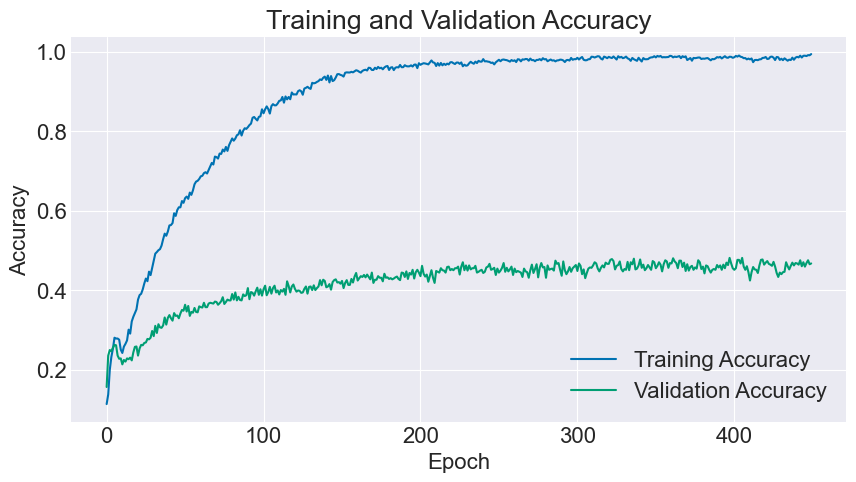

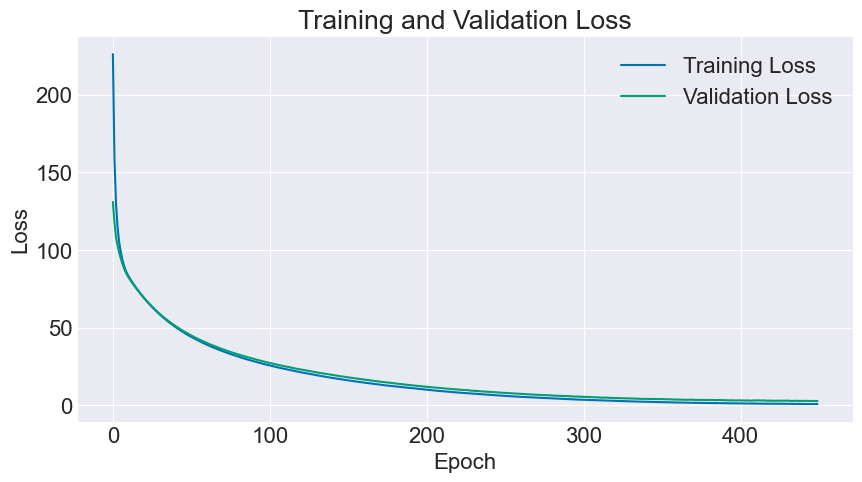

In [ ]:
# YOUR CODE HERE


plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



### 1c. Visualize predictions

Make a 5x5 grid of the first 25 images in the test dataset. Label each with the predicted class label string (English label, not an int code).

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


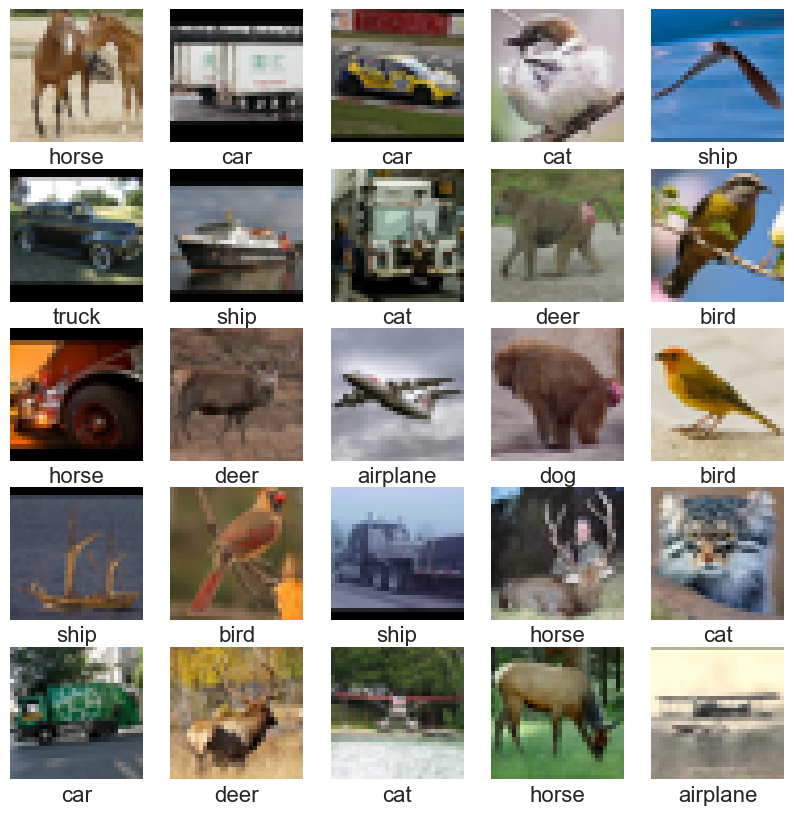

In [ ]:
# # YOUR CODE HERE
predictions = model.predict(x_test_transposed)

# Visualize predictions
x_test_transnormal = x_test_transposed / 255.0

# Make a 5x5 grid of the first 25 images in the test dataset
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test_transnormal[i], cmap=plt.cm.binary)
    # Get the predicted class label string (English label, not an int code)
    predicted_label = classes[np.argmax(predictions[i])]
    plt.xlabel(predicted_label)
plt.show()



### 1d. Questions

**Question 1:** What accuracy do you get on the STL-10 test set? Briefly summarize any non-default hyperparameters that you used to obtain this result.

**Question 2:** How do the loss and accurary results compare to the CNN project?

**Question 3:** Identify a few misclassifications. Is there a discernable pattern?

**Answer 1:**

Test accuracy: ~48.00% - used 600 interior units, 0.4 dropout rate, 0.1 reg, 450 epochs, 250 batch size, 0.0001 learning rate.

**Answer 2:**

CNN:

Final train accuracy: 0.8700

Final loss: 0.4206

Validation accuracy: 0.4400

TF_CNN:

Final train accuracy: 0.9932

Final loss: 0.7306

Final validation accuracy: 0.4670

Final training accuracy is higher, but so is loss, likely due to more generalization with a higher dropout rate. The final validation accuracy is also a little higher, indicating that the network did indeed generalize better. Final test accuracy is also slightly higher than CNN, which had 46.50%.

**Answer 3:**

Birds are often misclassified as various objects and animals due to their varying shapes/patterns/positions, and vehicles sometimes get confused since they appear so similar in terms of their edges.

## Task 2: Transfer learning

Here you will use TensorFlow to download the pre-trained MobileNetV2 network (you may also use another network like InceptionV3, VGG19, or EfficientNet, but MobileNetV2 likely will run noticeably faster on your machine). We will use transfer learning to accelerate training to solve a novel problem: **the binary classification task of discriminating whether an image is of a hotdog or not.**

### Overview

- Remove the output layer, add a new Dense output layer.
- Freeze (disable) training on all non-output layers.
- Train the last layer on a food dataset. Assess performance. Plot some example images and their classification below.

### 2a. Download and load in hotdot image dataset

Download the **food dataset** from the project website, copy it into a `data` subfolder in your project directory.

Run the below code to load in the hot-dog-or-not dataset. Check the shapes to ensure everything is loaded in correctly. 

In [165]:
ds_base_dir='data/hot-dog-not-hot-dog/numpy/'

hotdog_train_x = np.load(os.path.join(ds_base_dir, 'train_x.npy'))
hotdog_train_y = np.load(os.path.join(ds_base_dir, 'train_y.npy'))
hotdog_test_x = np.load(os.path.join(ds_base_dir, 'test_x.npy'))
hotdog_test_y = np.load(os.path.join(ds_base_dir, 'test_y.npy'))

print(f'Training hotdog split shape: {hotdog_train_x.shape}. Should be (16000, 96, 96, 3)')
print(f'Test hotdog split shape: {hotdog_test_x.shape}. Should be (4000, 96, 96, 3)')

Training hotdog split shape: (16000, 96, 96, 3). Should be (16000, 96, 96, 3)
Test hotdog split shape: (4000, 96, 96, 3). Should be (4000, 96, 96, 3)


### 2b. Normalize hotdog dataset

Standardize both the train and test dataset according to the **same statistics** computed from the **training set**.

In [ ]:
# YOUR CODE HERE

# Extra line to fix the class names

classes = np.array(['hotdog', 'not-hotdog'])

# Compute the min and max from the training set
train_min = np.min(hotdog_train_x, axis=(0, 1, 2))
train_max = np.max(hotdog_train_x, axis=(0, 1, 2))

# Min-max normalize the datasets
hotdog_train_x = (hotdog_train_x - train_min) / (train_max - train_min)
hotdog_test_x = (hotdog_test_x - train_min) / (train_max - train_min)




### 2c. Create hotdog validation set

Set aside the last 20% of the training set as the validation set

In [167]:
# YOUR CODE HERE

#use last 20% of training data as validation data


hotdog_val_x = hotdog_train_x[-3200:]
hotdog_val_y = hotdog_train_y[-3200:]

#remove the last 20% of the training data

hotdog_train_x = hotdog_train_x[:-3200]
hotdog_train_y = hotdog_train_y[:-3200]








In [168]:
print(f'Validation hotdog split shape: {hotdog_val_x.shape}. Should be (3200, 96, 96, 3)')
print(f'Training hotdog split shape: {hotdog_train_x.shape}. Should be (12800, 96, 96, 3)')

Validation hotdog split shape: (3200, 96, 96, 3). Should be (3200, 96, 96, 3)
Training hotdog split shape: (12800, 96, 96, 3). Should be (12800, 96, 96, 3)


### 2d. Load in pre-trained MobileNetV2 network.

Load in a pre-trained MobileNetV2 network (look up constructor in [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/MobileNetV2) or look at the tutorial from class) and set it to a variable called `model`. Remember to make the network not trainable. Calling the `summary()` method on the network object should show you a table with many rows. The top and bottom rows should be:

    Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
    ┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
    │ input_layer_19      │ (None, 96, 96, 3) │          0 │ -                 │
    │ (InputLayer)        │                   │            │            
                                        
    ├─────────────────────┼───────────────────┼────────────┼───────────────────┤
    │ out_relu (ReLU)     │ (None, 3, 3,      │          0 │ Conv_1_bn[0][0]   │
    │                     │ 1280)             │            │                   │  
                                                                                                  
==================================================================================================

and you should see the following at the bottom:

    Total params: 2,257,984 (8.61 MB)
    Trainable params: 0 (0.00 B)
    Non-trainable params: 2,257,984 (8.61 MB)

In [169]:
# YOUR CODE HERE

# Load MobileNetV2 model
model = tf.keras.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    weights='imagenet',
    include_top=False
)

model.trainable = False

model.summary()

Model: "mobilenetv2_1.00_96"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_47      │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer_47[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

### 2e. Create augmented model

Create a new `keras::Sequential` augmented model with an output layer that has the correct number of units to deal with the hot-dog or not problem with your choice of optimizer, an appropriate loss, and metric(s).

#### Helpful links

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/AdamW

https://www.tensorflow.org/api_docs/python/tf/losses

In [170]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

# Set random seed for reproducibility
tf.random.set_seed(0)

#create augmenteed model using MobileNetV2

n_classes = 2

reg = 0.1

dropout_rate = 0.3


augmented_model= tf.keras.Sequential(
    [
        model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(n_classes, activation='softmax')
    ])
    


learning_rate = 0.0001
optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate)

augmented_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

augmented_model.summary()




# Evaluate the model
test_loss, test_accuracy = augmented_model.evaluate(hotdog_test_x, hotdog_test_y)
print(f"Test accuracy: {test_accuracy}")

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_33 (Flatten)            │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 2)              │        23,042 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,281,026 (8.70 MB)

 Trainable params: 23,042 (90.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.5388 - loss: 1.0731
Test accuracy: 0.5295000076293945


### 2f. Questions

**Question 4:** What is the accuracy and loss for the network with the untrained output layer on the test set? Explain why you got the accuracy value that you did.

**Question 5:** Briefly defend your choice of number of units in the output layer.

**Answer 4:**

Accuracy is ~53.00%, makes sense because the network in its current state is not trained to this data at all, so it's just making guesses and since there are only 2 classes, there is a 50/50 chance of picking the correct answer blind every time.

**Answer 5:**

Binary Classification problem, so we only need 2 units with softmax to determine if the image is a hotdog or not. Could have also swapped output layer for sigmoid and used 1 unit. NOTE: Had to create custom int classes when loading because class names were still STL-10.

In [172]:
# YOUR CODE HERE

### 2g. Fit the augmented model on the hotdog training data

Setting the verbose optional parameter to 2 will give you helpful printouts of performance on the validation set as it completes every epoch of training.

#### Training goal

You should aim to achieve at least 85% accuracy on the validation set. If everything is set up properly, you should only need to train for a very small number of epochs.


#### Note

If training time is taking much more than a few minutes per epoch on your computer, you could try reducing the number of data samples in train and validation. For example, by default train `N = 12800`. Try `N = 6400` instead. You could do the same for the validation set.

In [173]:
# YOUR CODE HERE
history = augmented_model.fit(hotdog_train_x, hotdog_train_y, epochs=3, batch_size=64, validation_data=(hotdog_val_x, hotdog_val_y))


Epoch 1/3
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 104ms/step - accuracy: 0.7404 - loss: 0.5810 - val_accuracy: 0.8466 - val_loss: 0.3422
Epoch 2/3
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.8696 - loss: 0.3074 - val_accuracy: 0.8719 - val_loss: 0.2819
Epoch 3/3
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - accuracy: 0.9052 - loss: 0.2327 - val_accuracy: 0.8906 - val_loss: 0.2478


### 2h. Plot hotdog results

Produce 2 high quality plots showing the following:

- Training and validation loss over epoch.
- Training and validation accuracy over epoch.

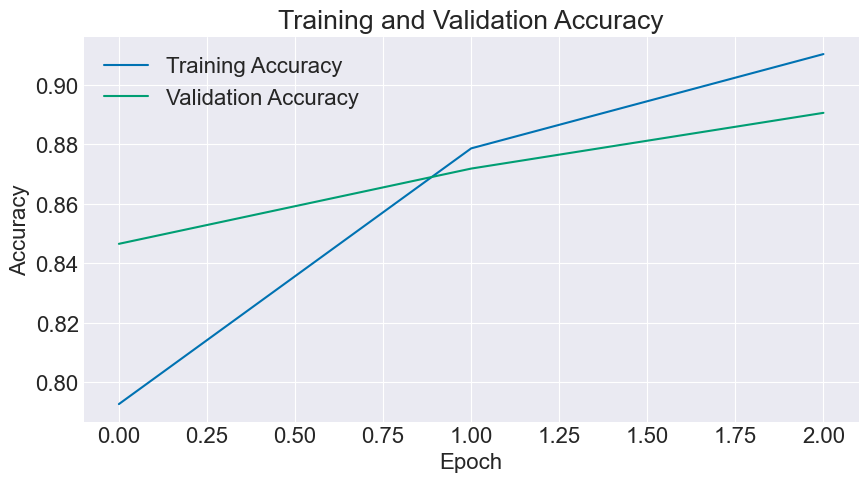

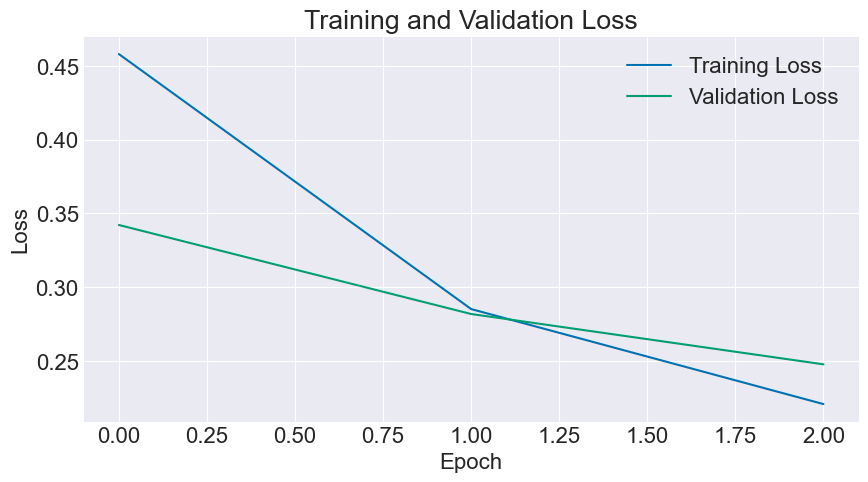

In [174]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### 2i. Visualize predictions on test set

Use your trained hotdog classifier to get the predicted classes for the first 25 **test set** samples. Then create a 5x5 grid of the first 25 test samples and label each with the predicted class string (English label, not an int code).
- If the prediction is correct, color the label *blue*.
- If the prediction is incorrect, color the label *red*.

**Note:**
- Depending on how you get the network predictions, TensorFlow may give you a vector of class probabilities. This could be shape `(N, 2)` or `(N,)`, depending on the output layer activation function that you used. Remember that if you have these probabilities, you need to recover the predicted class index (e.g. `0`, `1`) before you can label your plots.
- If `imshow` gives you warnings about clipping, check the range of the test samples. If your max is slightly higher than 1, either ignore the warning or divide by the max. 

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step


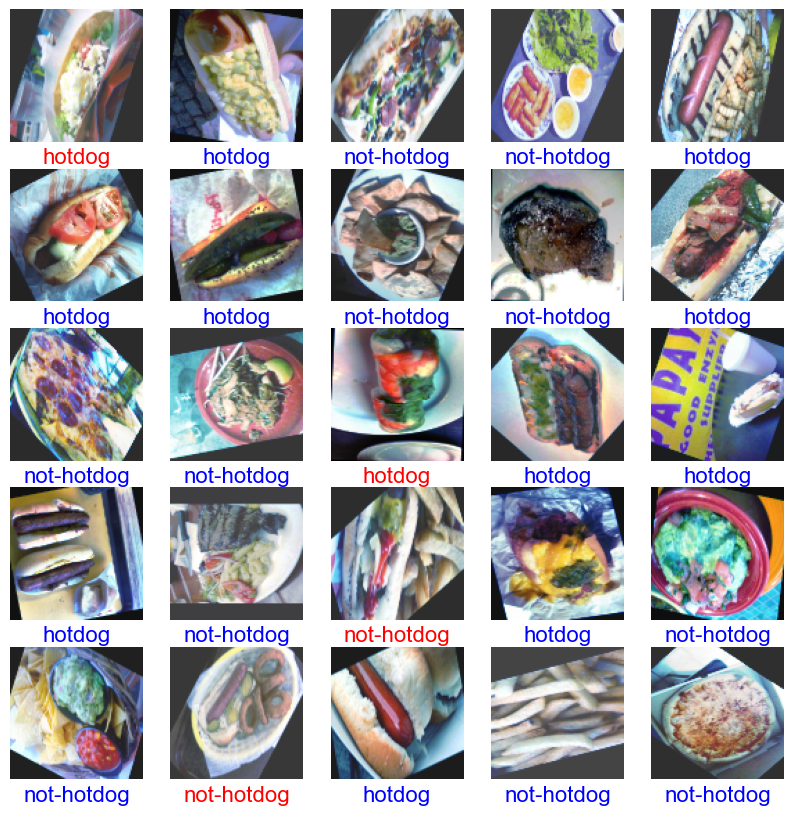

In [ ]:
# YOUR CODE HERE

predictions = augmented_model.predict(hotdog_test_x)

# Visualize predictions

#normalize data by dividing by the max pixel value
hotdog_test_x_transnormal = hotdog_test_x / hotdog_test_x.max()

# Make a 5x5 grid of the first 25 images in the test dataset

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow
    plt.imshow(hotdog_test_x_transnormal[i], cmap=plt.cm.binary)
    # Get the predicted class label string (English label, not an int code)
    predicted_label = classes[np.argmax(predictions[i])]
    # Get the true class label string (English label, not an int code)
    true_label = classes[hotdog_test_y[i]]
    # Set the label color to blue if the prediction is correct, else red
    color = 'blue' if predicted_label == true_label else 'red'
    plt.xlabel(predicted_label, color=color)
plt.show()
